In [49]:
# basic model
import sys
import random
import numpy as np

np.random.seed(10)

sys.path.append("../")
import pandas as pd
import os
import matplotlib as plt
import src.preprocessing as pp

#import seaborn as sns
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import plotly.express as px
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
    f1_score
)
from itertools import permutations
from typing import List, Tuple

# feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import resample

In [50]:
identifiers = ["date_id", "iid", "match", "wave"]

preference = ["pf_o_att", "pf_o_sin", "pf_o_int", "pf_o_fun", "pf_o_amb", "pf_o_sha"]

personal_info = ["field_cd", "age", "race", "income", "zipcode", "samerace", "goal"]

behaviour = ["go_out",
           "sports", "tvsports", "exercise", "dining", "museums", "art", "hiking", "gaming",
           "clubbing", "reading", "tv", "theater", "movies", "concerts", "music", "shopping",
           "yoga", "exphappy"]

looking_for = ["attr1_1", "sinc1_1", "intel1_1", "fun1_1", "amb1_1", "imprace", "imprelig"]

self_rating = [ "attr3_1", "sinc3_1", "intel3_1", "fun3_1", "amb3_1"]

to_drop = ["date_id_a", "date_id_b", "wave_a", "wave_b", 'Unnamed: 0', "latitude_a", "latitude_b", "longitude_a", "longitude_b", "distance", "from_a", "from_b", "zipcode_a", "zipcode_b"] #TODO clean text in from column

categorical = ["income_a", "income_b", "distance_bin"]

In [51]:
# read in data
df = pd.read_csv("../data/interim/single_row_date.csv")
df.drop(to_drop, axis = 1, inplace = True)


In [52]:
x = df.match_a.value_counts()
x[0]/(x[0]+x[1])

0.834248455730954

In [53]:
df["zipcode_area_b"] = df["zipcode_area_b"].replace("Not", 0)
df["zipcode_area_a"] = df["zipcode_area_a"].replace("Not", 0)

In [54]:
df = pd.get_dummies(df, columns = categorical)

In [55]:
# replace "Not applicable" with -1
df.columns[df.isnull().any()].tolist()
df.isnull().sum().sort_values(ascending=False).head(10)
df.dropna(inplace=True)

In [56]:
X = df[[column for column in df.columns if column!="match_a"]]
y = df["match_a"]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.30, stratify=y, shuffle=True
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2000, 125) (2000,)
(858, 125) (858,)


In [58]:
k = X_train.shape[1]

# select k most important features
# To start with we'll look at them all
X_train_fs, X_test_fs, all_vars, ns_df_sorted = pp.select_features(X_train, y_train, X_test, k=100, df=X)

In [59]:
ns_df_sorted.head(15)

,Feat_names,F_Scores
40,zipcode_area_b,2383.334757
17,zipcode_area_a,321.257732
41,age_difference,34.172069
51,income_a_89998.0 and 99998.0,15.024025
4,field_cd_a,8.094919
48,income_a_59998.0 and 69998.0,7.334792
46,income_a_19998.0 and 29998.0,4.848337
47,income_a_29998.0 and 39998.0,4.578022
49,income_a_69998.0 and 79998.0,3.172274
22,race_b,3.147542


accuracy: 0.8368298368298368
f1_score: 0.1358024691358025


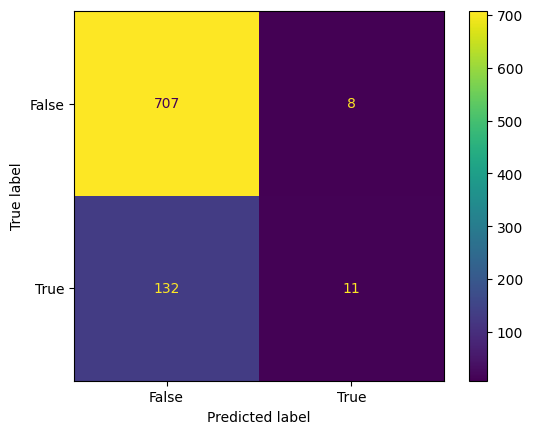

In [60]:
# logistic regression without feature selection
log_reg = pp.log_reg(X_train, y_train, X_test, y_test, X.columns)
print("accuracy:", log_reg["accuracy"])
print("f1_score:", log_reg["F1_score"])

accuracy: 0.831002331002331
f1_score: 0.07643312101910828


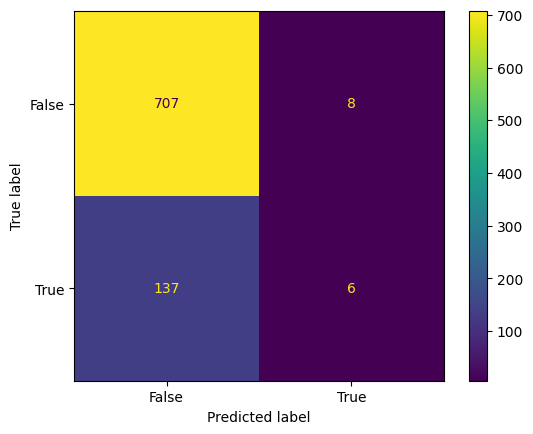

In [61]:
# logistic regression with feature selection
log_reg = pp.log_reg(X_train_fs, y_train, X_test_fs, y_test, X.columns)
print("accuracy:", log_reg["accuracy"])
print("f1_score:", log_reg["F1_score"])

In [62]:
train_df = X_train.copy()
train_df["match_a"] = y_train

In [63]:
# looking for best performing upsample multiplier
# for m in [1.2, 1.5, 1.7, 2, 2.2, 2.5, 2.7, 3, 3.2, 3.5, 3.7, 4]:
#     print("Upsample multiplier: ", m)
#     pp.resample_data(train_df, m, X_test, y_test, LogisticRegression(random_state=42, max_iter= 10000))

X_train shape is:  (2733, 125) X_train shape is:  (2733,)
Precision: 0.3018867924528302
Recall: 0.44755244755244755
Accuracy: 0.7354312354312355
F1 Score: 0.3605633802816901


LogisticRegression(max_iter=10000, random_state=42)

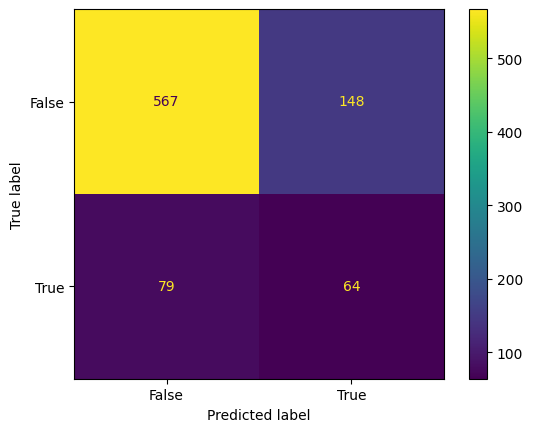

In [64]:
pp.resample_data(train_df, 3.2, X_test, y_test, LogisticRegression(random_state=42, max_iter= 10000))